# Super Resolution using CNN

It is possible to represent the entire process of Super-Resolution as a Deep Convolution Neural Network. The start-of-the-art model for Super-resolution is based on GANs. This repository contains the CNN-based implementaion.This model is an end to end mapping between low and high-resolution images. This model takes input 64x64 image and outputs a 128x128 image.

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import tensorflow.keras
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
from tensorflow.keras import models,layers,datasets,optimizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb
import cv2
import os
import time

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## Loading the Dataset

The model is trained using `Linnaeus 5` Dataset. The training set consists of 6000 images and the test set has 2000 images. All the images have resolution 256x256.


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
def load_data():
    train_1 = load_images_from_folder('d1/train/berry')
    train_2 = load_images_from_folder('d1/train/bird')
    train_3 = load_images_from_folder('d1/train/dog')
    train_4 = load_images_from_folder('d1/train/flower')
    train_5 = load_images_from_folder('d1/train/other')
    
    
    test_1 = load_images_from_folder('d1/test/berry')
    test_2 = load_images_from_folder('d1/test/bird')
    test_3 = load_images_from_folder('d1/test/dog')
    test_4 = load_images_from_folder('d1/test/flower')
    test_5 = load_images_from_folder('d1/test/other')
    
    train = train_1 + train_2 + train_3 + train_4 + train_5
    test = test_1 + test_2 + test_3 + test_4 + test_5
    
    return train, test

In [5]:
train, test = load_data()

In [6]:
print(len(train))
print(len(test))

6000
2000


## Data Preprocessing

Since the model takes `res_low`x`res_low`(64x64) image as input and outputs a `res_high`x`res_high`(128x128) image, the original 256x256 images were resized to the required dimensions.

In [7]:
res_high = 128
res_low = 64

In [8]:
def reduce_resolution(data, res):
    low_res = []
    for img in data:
        img_low_res = cv2.resize(img,(res,res))
        low_res.append(img_low_res)
        
    return low_res

In [9]:
train = reduce_resolution(train,res_high)
test = reduce_resolution(test,res_high)

train_low = reduce_resolution(train,res_low)
test_low = reduce_resolution(test,res_low)

In [10]:
train = np.reshape(train,(len(train),res_high,res_high,3))
test = np.reshape(test,(len(test),res_high,res_high,3))

train_low = np.reshape(train_low,(len(train_low),res_low,res_low,3))
test_low = np.reshape(test_low,(len(test_low),res_low,res_low,3))

In [11]:
print(train.shape)
print(test.shape)

print(train_low.shape)
print(test_low.shape)

(6000, 128, 128, 3)
(2000, 128, 128, 3)
(6000, 64, 64, 3)
(2000, 64, 64, 3)


In [12]:
data_train = train_low
labels_train = train

data_test = test_low
labels_test = test

## Model Architecture

The model architecture used here is similar to the one given in 'Reconstructing Obfuscated Human Faces' project report by Jacob Conrad Trinidad.


After `BatchNorm` the input is sent through 4 `Conv` layers. Then it is sent through 3 block of `ResNet`, where each block has 2 `Conv` layers. Then finally we have 4 `Conv Transpose` layers. All the Conv and Conv Transpose layers are followed by `Relu` and `BatchNorm` except the last one. The last layer uses `tanh` activation which is followed by a `Rescaling` to 255.

In [13]:
def relu_batch_norm(inputs):
    relu = layers.ReLU()(inputs)
    batch_norm = layers.BatchNormalization()(relu)
    return batch_norm

In [14]:
def conv_layer(x, filters: int, kernel_size: int = 3, strides: int = 1):
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(x)
    y = relu_batch_norm(y)
    return y

In [15]:
def residual_block(x, filters: int, kernel_size: int = 3, strides: int = 1):
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(x)
    y = relu_batch_norm(y)
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(y)
    y = relu_batch_norm(y)
    
    out = layers.Add()([x, y])
    out = relu_batch_norm(out)
    
    return out

In [16]:
def conv_layer_transpose(x, filters: int, kernel_size: int = 4, strides: int = 2):
    y = layers.Conv2DTranspose(kernel_size=kernel_size,
               strides=strides,
               filters=filters,
               padding="same")(x)
    y = relu_batch_norm(y)
    return y

In [17]:
def create_res_net():
    
    inputs = Input(shape=(64, 64, 3))
    
    t = layers.BatchNormalization()(inputs)
    t = conv_layer(t, kernel_size=9,
           strides=1,
           filters=64)
    t = conv_layer(t, kernel_size=4,
           strides=2,
           filters=64)
    t = conv_layer(t, kernel_size=4,
           strides=2,
           filters=128)
    t = conv_layer(t, kernel_size=4,
           strides=2,
           filters=256)
    
    for i in range(0,3):
        t = residual_block(t, kernel_size=3,
               strides=1,
               filters=256)
    
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=256)
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=128)
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=64)
    t = conv_layer_transpose(t, kernel_size=4,
           strides=2,
           filters=64)
    
    t = layers.Conv2DTranspose(kernel_size=9,
           strides= 1,
           filters=3,
           padding="same")(t)
    t = layers.Activation(activation='tanh')(t)
    
    output = layers.experimental.preprocessing.Rescaling(255)(t)
        
    model = Model(inputs, output)

    return model

In [18]:
model = create_res_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 64)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [19]:
checkpoint_path = "savemodel/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
!ls {checkpoint_dir}
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest
model.load_weights(latest)

checkpoint  cp-0000.ckpt.data-00000-of-00001  cp-0000.ckpt.index


## Load Pre-Trained VGG16


In [20]:
model_VGG16_pretrained = VGG16(weights='imagenet', include_top = False, input_shape=(128,128,3))
model_VGG16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [21]:
layer_name = 'block2_conv2'
model_VGG16_custom = Model(inputs=model_VGG16_pretrained.input,
                                 outputs=model_VGG16_pretrained.get_layer(layer_name).output)
model_VGG16_custom.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
_____________________________________________________

## Loss Functions


In [22]:
def perceptual_loss_function(y_actual, y_predicted):
        
    y_actual = kb.reshape(y_actual,(mini_batch_size, 128, 128, 3))
    y_predicted = kb.reshape(y_predicted,(mini_batch_size, 128, 128, 3))
    y = y_actual + y_predicted
    
    x = model_VGG16_custom(y)
    (m,H,W,C) = x.shape
    
    l = (1/(H*W*C*m)) * tf.square(x[0]-x[1])
    loss = l
    
    return kb.sum(loss)

In [23]:
def pixel_loss_function(y_actual, y_predicted):
    
    (m,H,W,C) = y_predicted.shape
    l = (1/(H*W*C*m)) * tf.square(y_actual-y_predicted)
    loss = l
    
    return kb.sum(loss)

In [24]:
def loss_function(y_actual, y_predicted):
    
    y_actual = tf.cast(y_actual, tf.float32)
    y_predicted = tf.cast(y_predicted, tf.float32)
    
    l_pixel = pixel_loss_function(y_actual,y_predicted)
    l_perceptual = perceptual_loss_function(y_actual,y_predicted)
    
    return l_pixel + l_perceptual

## Model Optimizer

The loss function used in various papers of `Super Resolution` is more complex. 
It uses a linear combination of `Pixel Loss` and `Perceptual Loss` as the loss function. The `MeanSquaredError` loss function resembles the Pixel Loss and works well for this naive model.

The model uses Adam Optimizer with pretty much standard values of `beta_1`, `beta_2` and `epsilon`. The learning_rate was experimented with and values of `0.0008` was found suitable.

In [25]:
optimizer = optimizers.Adam(learning_rate=0.001, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            epsilon=1e-08, 
                            amsgrad=False, 
                            clipvalue=0.5)

In [26]:
history = {}
history['loss'] = []
history['accuracy'] = []
history['test_accuracy'] = []

In [27]:
def model_fit(epochs, mini_batch_size):
    
    train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(mini_batch_size)

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        loss_value = 0

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            t2 = time.process_time()
            with tf.GradientTape() as tape:

                logits = model(x_batch_train, training=True)
                loss_value = loss_function(y_batch_train, logits)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            if step % 20 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("Time taken for step: " + str(round(time.process_time()-t2, 2)) + "s")
                t2 = time.process_time()

        if epoch % 2 == 0:
            history['loss'].append(loss_value)
    #         acc = model.evaluate(data_train,labels_train)
    #         history['accuracy'].append(acc)

In [ ]:
mini_batch_size = 8
epochs = 1

model_fit(epochs, mini_batch_size)        

## Loss vs Epochs


In [ ]:
plt.plot(history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Results


In [28]:
test_eval = model.predict(data_test)

In [29]:
print(test_eval.shape)

(2000, 128, 128, 3)


In [47]:
def compute_cost(d1, d2):
    l = []
    for i in range(0,len(d1)):
        a = d1[i]
        b = d2[i]
        c = abs((b-a))
        c = c.sum()/(64*64*3)
        if c <= 12:
            l.append(i)
    return l

In [48]:
min_index = compute_cost(test_eval,labels_test)
print(min_index)

[433, 507, 562, 580, 705, 756, 781, 1765]


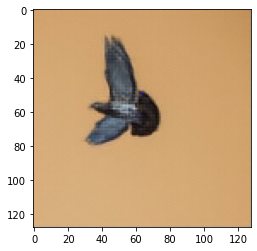

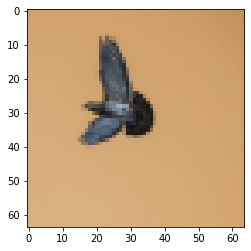

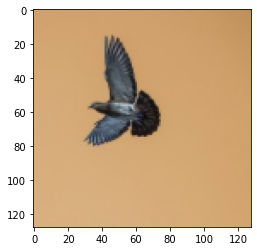

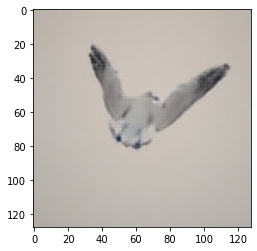

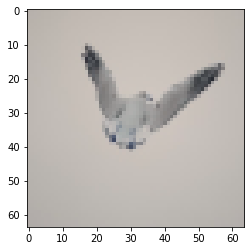

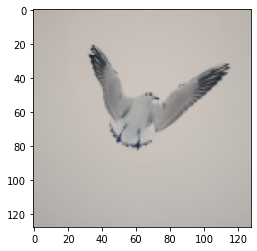

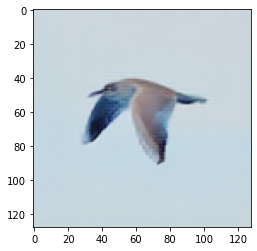

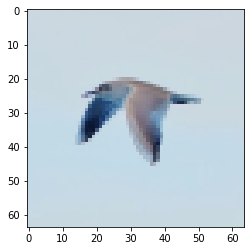

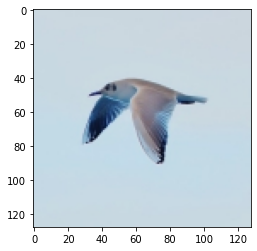

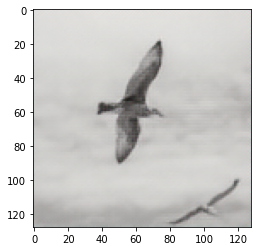

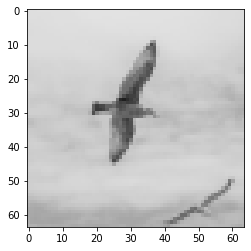

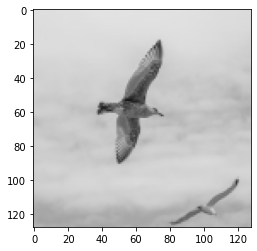

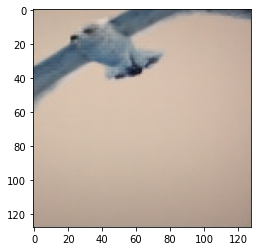

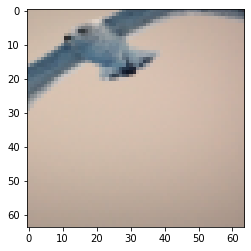

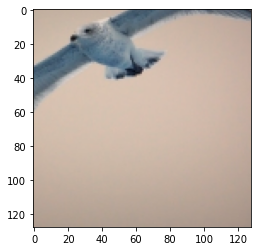

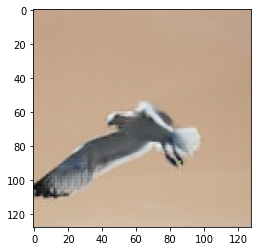

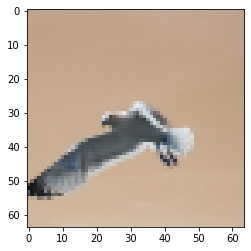

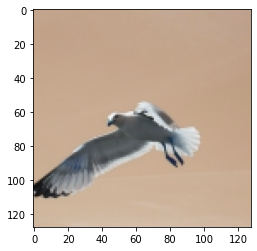

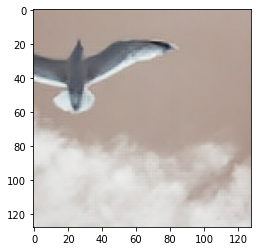

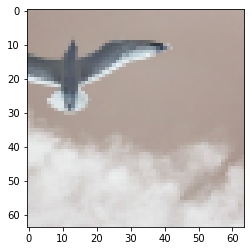

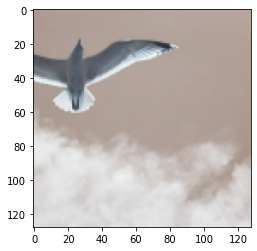

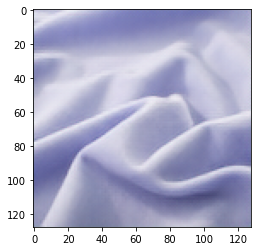

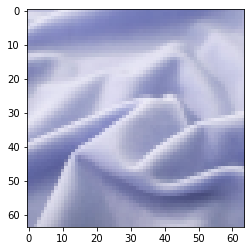

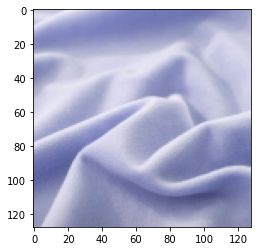

In [50]:
for i in min_index:
    
    plt.imshow(test_eval[i].astype(np.uint8))
    plt.show()
    
    plt.imshow(data_test[i].astype(np.uint8))
    plt.show()
    
    plt.imshow(labels_test[i].astype(np.uint8))
    plt.show()

In [51]:
import math

In [52]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr 

In [61]:
def compute_psnr(predicted, actual):
    all_val = []
    min_psnr = []
    for i in range(0,len(predicted)):
        psnr = PSNR(actual[i], predicted[i])
        all_val.append(psnr)
        if psnr > 35:
            min_psnr.append(i)
        
    return all_val, min_psnr

In [62]:
get_psnr, min_psnr = compute_psnr(test_eval,labels_test)

In [63]:
print(min_psnr)

[705, 781, 927, 1701, 1765]


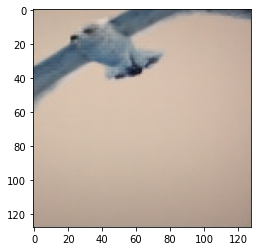

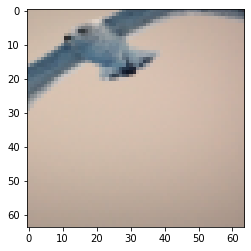

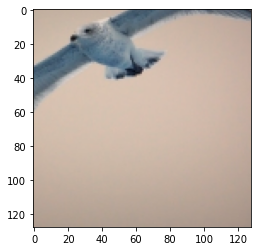

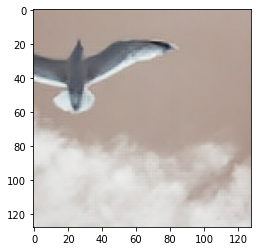

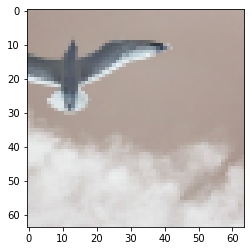

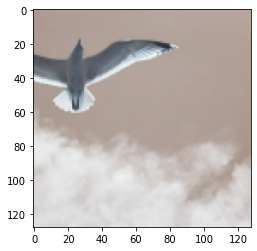

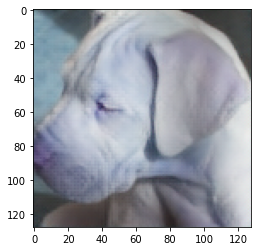

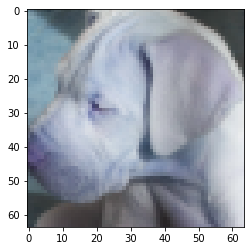

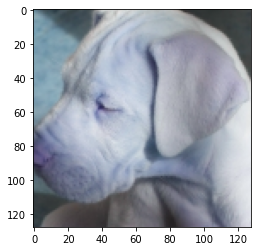

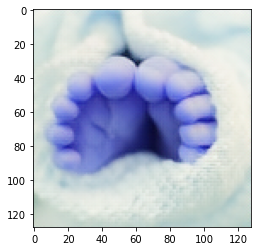

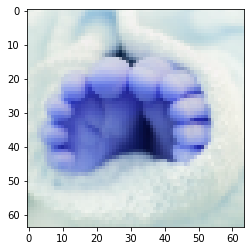

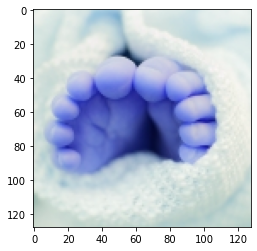

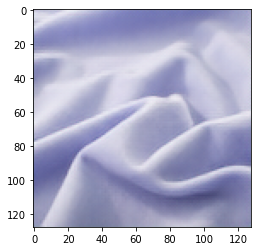

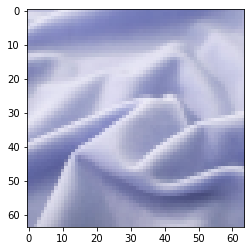

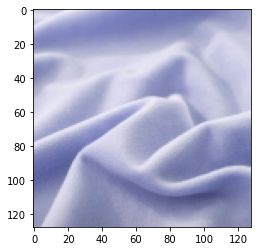

In [64]:
for i in min_psnr:
    
    plt.imshow(test_eval[i].astype(np.uint8))
    plt.show()
    
    plt.imshow(data_test[i].astype(np.uint8))
    plt.show()
    
    plt.imshow(labels_test[i].astype(np.uint8))
    plt.show()